In [1]:
import numpy as np
import keras
from keras.preprocessing.image import array_to_img, img_to_array, load_img
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, labels, batch_size=4, dim=(50,50), n_channels=3, n_classes=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.n = len(list_IDs)
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        for i, ID in enumerate(list_IDs_temp):
            X[i, ] = img_to_array(load_img(ID))
            y[i] = self.labels[ID]
        return X, y

Using TensorFlow backend.


In [2]:
# Generate file IDs
import os
from PIL import Image
training_dir = 'F:/Breast histopathology image analysis/breast-histopathology-images'
patient_list = os.listdir(training_dir)
gr1_IDs = []
gr0_IDs = []
labels = dict()
for i in patient_list:
    this_pt_gr1 = training_dir + '/' + i + '/1'
    this_pt_gr0 = training_dir + '/' + i + '/0'
    gr1_IDs.extend([this_pt_gr1 + '/' + x for x in os.listdir(this_pt_gr1)])
    gr0_IDs.extend(this_pt_gr0 + '/' + x for x in os.listdir(this_pt_gr0))
for x in gr1_IDs:
    labels[x] = 1
for x in gr0_IDs:
    labels[x] = 0

In [3]:
# generate training and testing set
training_1 = np.random.choice(gr1_IDs, int(len(gr1_IDs)/2), replace=False)
testing_1 = np.setdiff1d(gr1_IDs, training_1)
training_0 = np.random.choice(gr0_IDs, int(len(gr0_IDs)/2), replace=False)
testing_0 = np.setdiff1d(gr0_IDs, training_0)
training_set = np.append(training_1, training_0)
testing_set = np.append(testing_1, testing_0)

In [4]:
# analyze 1s and 0s
import matplotlib.pyplot as plt
num = [len(gr0_IDs), len(gr1_IDs)]
index = ('0','1')
bar_width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(index, num,align='center',
                color='grey', width=0.5
                )
plt.title('size of each data category')
plt.show()
fig.savefig('cat_n.png', dpi=200)


<Figure size 640x480 with 1 Axes>

In [5]:
# downsample 0s
gr0_IDs_ds = np.random.choice(gr0_IDs, len(gr1_IDs), replace=False)
training_1 = np.random.choice(gr1_IDs, int(len(gr1_IDs)/2), replace=False)
testing_1 = np.setdiff1d(gr1_IDs, training_1)
training_0 = np.random.choice(gr0_IDs_ds, int(len(gr0_IDs_ds)/2), replace=False)
testing_0 = np.setdiff1d(gr0_IDs_ds, training_0)
training_set = np.append(training_1, training_0)
testing_set = np.append(testing_1, testing_0)

In [6]:
gr0_res = np.setdiff1d(gr0_IDs, gr0_IDs_ds)
res_set = np.array(gr0_res)

In [7]:
params = {'dim': (50,50),
          'batch_size':2048,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True}
training_generator = DataGenerator(training_set, labels, **params)
testing_generator = DataGenerator(testing_set, labels, **params)
res_generator = DataGenerator(res_set, labels, **params)

In [8]:
# build model
import argparse
import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

In [9]:
vgg_model = keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(50, 50, 3),classes=2)
for layer in vgg_model.layers[:-4]:
    layer.trainable = False
k=0
for layer in vgg_model.layers:
        k=k+1
print(k)
vgg_model.summary()

19
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
_______

In [10]:
n_classes = 1
vgg = Sequential()
vgg.add(vgg_model)
vgg.add(Flatten())
vgg.add(Dense(64))
vgg.add(Activation('relu'))
vgg.add(Dropout(0.5))
vgg.add(Dense(n_classes))
vgg.add(Activation('sigmoid'))

In [11]:
vgg.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [12]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from time import time
filepath = 'F:/Breast histopathology image analysis/weights_improv_{epoch:02d}_{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
history = vgg.fit_generator(generator=training_generator,
                    validation_data=testing_generator,
                   epochs=25,
                  steps_per_epoch=training_generator.n/training_generator.batch_size,
                  validation_steps = testing_generator.n/testing_generator.batch_size,
                callbacks = [tensorboard, checkpoint])

Epoch 1/25
39/38 [==============================] - 58s 1s/step - loss: 0.9748 - acc: 0.6138 - val_loss: 0.5574 - val_acc: 0.6819

Epoch 00001: val_acc improved from -inf to 0.68187, saving model to F:/Breast histopathology image analysis/weights_improv_01_0.68.hdf5
Epoch 2/25
39/38 [==============================] - 44s 1s/step - loss: 0.6819 - acc: 0.5391 - val_loss: 0.6479 - val_acc: 0.6928

Epoch 00002: val_acc improved from 0.68187 to 0.69285, saving model to F:/Breast histopathology image analysis/weights_improv_02_0.69.hdf5
Epoch 3/25
39/38 [==============================] - 45s 1s/step - loss: 0.6424 - acc: 0.6538 - val_loss: 0.5743 - val_acc: 0.7774

Epoch 00003: val_acc improved from 0.69285 to 0.77745, saving model to F:/Breast histopathology image analysis/weights_improv_03_0.78.hdf5
Epoch 4/25
39/38 [==============================] - 45s 1s/step - loss: 0.6235 - acc: 0.6586 - val_loss: 0.5235 - val_acc: 0.7644

Epoch 00004: val_acc did not improve from 0.77745
Epoch 5/25
3

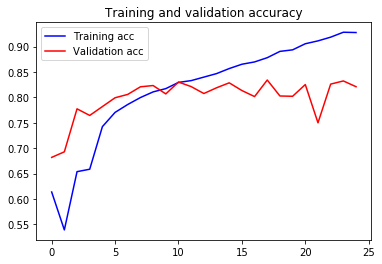

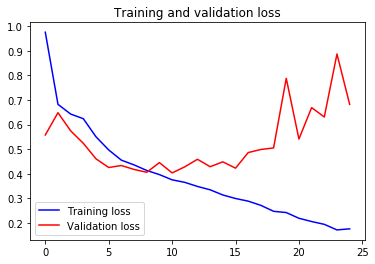

In [14]:
hist1 = history
acc = hist1.history['acc']
val_acc = hist1.history['val_acc']
loss = hist1.history['loss']
val_loss = hist1.history['val_loss']

epochs = range(len(acc))
import matplotlib.pyplot as plt
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('vggacc.png',dpi=120)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('vggloss.png',dip=120)

plt.show()

In [18]:
vgg.load_weights('F:/Breast histopathology image analysis/weights_improv_18_0.83.hdf5')
res_pred = vgg.evaluate_generator(res_generator, verbose=1)

57/57 [==============================] - 43s 751ms/step


In [20]:
np.save('F:/Breast histopathology image analysis/vgg_25epoch_ds.npy', history.history)

In [ ]:
history = {'loss':[], 'val_loss':[], 'acc':[], 'val_acc':[]}
import tensorflow as tf
for e in tf.train.summary_iterator('F:/Breast histopathology image analysis/logs/1543781253.0051723/events.out.tfevents.1543781257.DESKTOP-N6SS82Q'):
    for v in e.summary.value:
        if v.tag == 'loss':
            history['loss'].append(v.simple_value)
        if v.tag == 'val_loss':
            history['val_loss'].append(v.simple_value)
        if v.tag == 'val_acc':
            history['val_acc'].append(v.simple_value)
        if v.tag == 'acc':
            history['acc'].append(v.simple_value)
print(history)
np.save('F:/Breast histopathology image analysis/vgg_50epoch.npy', history)